In [1]:
#from graphviz import Digraph
#from torch.autograd import Variable

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

#from utils import ALL_LETTERS, N_LETTERS
#from utils import load_data, letter_to_tensor, line_to_tensor, random_training_example

#import os
#os.environ["PATH"] += os.pathsep + 'C:/Users/Erick/miniconda3/envs/pytorch_examples/Library/bin/graphviz/'

In [2]:
#Get data from csv file
pddata_train = pd.read_csv("data/stock_price/google/Google_Stock_Price_Train.csv")
#pddata_test = pd.read_csv("data/stock_price/google/Google_Stock_Price_Test.csv") 

# Preview the first 5 lines of the loaded data 
pddata_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [3]:
#split training data into two, test and training sets

data = pddata_train.loc[:, ["Open"]].values

data_train = data[0:1006]
data_test = data[1006:]

#data.shape

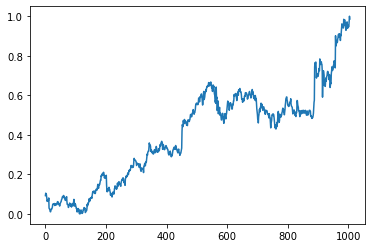

In [101]:
# feature scalling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range= (0,1)) # defining of Scaler

data_train_scaled = scaler.fit_transform(data_train) # applying to Scaler to train
data_test_scaled = scaler.fit_transform(data_test) # applying to Scaler to train

plt.plot(data_train_scaled)
plt.show()

In [5]:
# We add first 50 locution to "X_train" and we 51. locution to "y_train" .
X_train = []
y_train = []
timesteps = 50

#This loop, makes X, Y trainings pairs from data_train_scaled list.
#data_train_scaled has 1258 items, items from 0 to 49, will be X[0] and item 50 will be Y[0]
#items 50 to 99 will be X[1], item 100 will be Y[1], and so on. This way previous 50 items will be
#the input to estimate the next value.
for i in range(timesteps, data_train_scaled.shape[0]):
    X_train.append(data_train_scaled[i-timesteps:i,0])
    y_train.append(data_train_scaled[i,0])

X_train, y_train = np.array(X_train, dtype=np.float32), np.array(y_train, dtype=np.float32)


# Reshaping
#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Dimension of array is 3.
y_train = y_train.reshape(y_train.shape[0], 1)  # Dimension of array is 3.

In [83]:
class LSTM(torch.nn.Module):

    def __init__(self, input_size, output_size):
        super(LSTM, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = output_size
        self.output_size = output_size
        
        self.forget = torch.nn.Linear(input_size + self.hidden_size, output_size)
        self.keep1 = torch.nn.Linear(input_size + self.hidden_size, output_size)
        self.keep2 = torch.nn.Linear(input_size + self.hidden_size, output_size)
        self.output = torch.nn.Linear(input_size + self.hidden_size, output_size)
        self.outputPred = torch.nn.Linear(output_size, 1)
        
    def forward(self, input_tensor, hidden_tensor, cell_tensor):
        
        combined_input_hidden = torch.cat((input_tensor, hidden_tensor), 1)
        
        ft = torch.sigmoid(self.forget(combined_input_hidden))
        it = torch.sigmoid(self.keep1(combined_input_hidden))
        cell_candidate = torch.tanh(self.keep2(combined_input_hidden))
        
        new_cell = (ft * cell_tensor) + (it * cell_candidate)
        
        ot = torch.sigmoid(self.output(combined_input_hidden))
        
        new_hidden = ot * torch.tanh(new_cell)
        
        output = self.outputPred(new_hidden)
        
        return output, new_hidden, new_cell
    
    def init_hidden(self):
        return torch.zeros(self.input_size, self.output_size)

In [8]:
lstm = LSTM(1, 50)


criterion = torch.nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate)

In [45]:
def train(price_input_tensor, price_target_tensor):
    hidden = lstm.init_hidden()
    cell = lstm.init_hidden()
    
    for i in range(price_input_tensor.size()[0]):
        
        output, hidden, cell = lstm(torch.reshape(price_input_tensor[i], [1, 1]), hidden, cell)
        
    loss = criterion(output, price_target_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

4999 50.0 0.0003
9999 100.0 0.0001


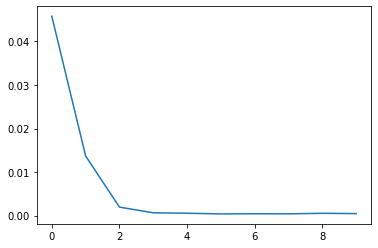

In [46]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 10000

for i in range(n_iters):
    
    rand_index = np.random.choice(np.arange(0, X_train.shape[0]), 1)
    
    torch_X_train = torch.from_numpy(X_train[rand_index])
    torch_y_train = torch.from_numpy(y_train[rand_index])
    
    output, loss = train(torch_X_train[0], torch_y_train)
    current_loss += loss
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        print(f"{i} {i/n_iters*100:.1f} {loss:.4f}")
        
plt.figure()
plt.plot(all_losses)
plt.show()

### Test model using training data

First lest test the model using never seen before data.
This data consist in 252 samples, we will take from 0 to 49 elements of the list and store as our prediction 1, then take from 1 to 50 and store prediction 2, and so on.

In [148]:
#prepare test data

# We add first 50 locution to "X_train" and we 51. locution to "y_train" .
X_test = []
y_test = []
timesteps = 50

#This loop, makes X, Y training pairs from data_train_scaled list.
#data_train_scaled has 1258 items, items from 0 to 49, will be X[0] and item 50 will be Y[0]
#items 50 to 99 will be X[1], item 100 will be Y[1], and so on. This way previous 50 items will be
#the input to estimate the next value.
for i in range(timesteps, data_test_scaled.shape[0]):
    X_test.append(data_test_scaled[i-timesteps:i,0])
    y_test.append(data_test_scaled[i,0])

X_test, y_test = np.array(X_test, dtype=np.float32), np.array(y_test, dtype=np.float32)


# Reshaping
#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Dimension of array is 3.
y_train = y_train.reshape(y_train.shape[0], 1)  # Dimension of array is 3.

In [149]:
#test model with test data

predictions = []

with torch.no_grad():
    
    for i in range(X_test.shape[0]):
        
        hidden = lstm.init_hidden()
        cell = lstm.init_hidden()
        
        torch_X_test = torch.from_numpy(X_test[i])


        for j in range(torch_X_test.size()[0]):
            output, hidden, cell = lstm(torch.reshape(torch_X_test[j], [1, 1]), hidden, cell)
        
        predictions.append(output[0])

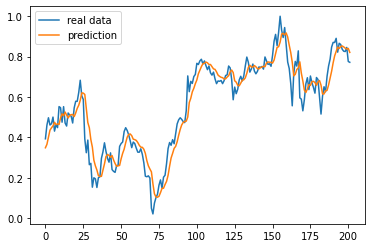

In [150]:
plt.plot(data_test_scaled[50:])
plt.plot(predictions)
plt.legend(["real data", "prediction"])
plt.show()

For the second test lets just take the first 50 elements, predict 51 sample, and then use the predicted sample as the new element together with the previous 49 to predict next sample, then use the new sample for the prediction, and so on.

In [153]:
predictions = []

n_iterations = data_test_scaled.shape[0]

#Get only first 50 samples
X_test = data_test_scaled[0:50]
X_test = np.array(X_test, dtype=np.float32)

with torch.no_grad():
        
    for i in range(n_iterations):
        
        hidden = lstm.init_hidden()
        cell = lstm.init_hidden()
        
        torch_X_test = torch.from_numpy(X_test[i:50+i])


        for j in range(torch_X_test.size()[0]):
            output, hidden, cell = lstm(torch.reshape(torch_X_test[j], [1, 1]), hidden, cell)
        
        #Add new prediction to test dataset
        X_test = np.append(X_test, output[0])
        
        predictions.append(output[0])

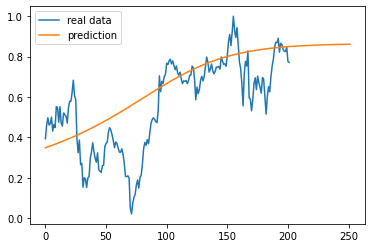

In [154]:
plt.plot(data_test_scaled[50:])
plt.plot(predictions)
plt.legend(["real data", "prediction"])
plt.show()

### Try predicting more than one days in the future 

In [91]:
class LSTM2(torch.nn.Module):

    def __init__(self, input_size, hidden_size,output_size):
        super(LSTM2, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.forget = torch.nn.Linear(input_size + self.hidden_size, hidden_size)
        self.keep1 = torch.nn.Linear(input_size + self.hidden_size, hidden_size)
        self.keep2 = torch.nn.Linear(input_size + self.hidden_size, hidden_size)
        self.output = torch.nn.Linear(input_size + self.hidden_size, hidden_size)
        self.outputPred = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, input_tensor, hidden_tensor, cell_tensor):
        
        combined_input_hidden = torch.cat((input_tensor, hidden_tensor), 1)
        
        ft = torch.sigmoid(self.forget(combined_input_hidden))
        it = torch.sigmoid(self.keep1(combined_input_hidden))
        cell_candidate = torch.tanh(self.keep2(combined_input_hidden))
        
        new_cell = (ft * cell_tensor) + (it * cell_candidate)
        
        ot = torch.sigmoid(self.output(combined_input_hidden))
        
        new_hidden = ot * torch.tanh(new_cell)
        
        output = self.outputPred(new_hidden)
        
        return output, new_hidden, new_cell
    
    def init_hidden(self):
        return torch.zeros(self.input_size, self.hidden_size)

In [102]:
#prepare test data

# We add first 50 locution to "X_train" and we 51. locution to "y_train" .
X_test = []
y_test = []
X_train = []
y_train = []
timesteps = 50
train_length = data_train_scaled.shape[0] - timesteps
prediction_number = 5
last_item_to_train = train_length - prediction_number

#This loop, makes X, Y training pairs from data_train_scaled list.
#data_train_scaled has 1258 items, items from 0 to 49, will be X[0] and items 50 to 54 will be Y[0]
#items 50 to 99 will be X[1], items 100 to 104 will be Y[1], and so on. This way previous 50 items will be
#the input to estimate the next value.
for i in range(timesteps, timesteps + last_item_to_train + 1):
    X_train.append(data_train_scaled[i-timesteps:i,0])
    y_train.append(data_train_scaled[i:i+prediction_number,0])

X_train, y_train = np.array(X_train, dtype=np.float32), np.array(y_train, dtype=np.float32)

# Reshaping
#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Dimension of array is 3.
#y_train = y_train.reshape(y_train.shape[0], 1)  # Dimension of array is 3.


for i in range(timesteps, data_test_scaled.shape[0]):
    X_test.append(data_test_scaled[i-timesteps:i,0])
    #y_test.append(data_test_scaled[i:i+prediction_number,0])

X_test = np.array(X_test, dtype=np.float32)
#y_test = np.array(y_test, dtype=np.float32)


# Reshaping
#X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Dimension of array is 3.
#y_train = y_train.reshape(y_train.shape[0], 1)  # Dimension of array is 3.

In [127]:
lstm = LSTM2(1, 50, prediction_number)


criterion = torch.nn.MSELoss()
learning_rate = 0.01
optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate)

In [128]:
#borrar
hidden = lstm.init_hidden()
cell = lstm.init_hidden()

torch_X_train = torch.from_numpy(X_train[rand_index])
torch_y_train = torch.from_numpy(y_train[rand_index])

torch_X_train
output, hidden, cell = lstm(torch.reshape(torch_X_train[0][0], [1, 1]), hidden, cell)
loss = criterion(output, torch_y_train)

In [129]:
def train(price_input_tensor, price_target_tensor):
    hidden = lstm.init_hidden()
    cell = lstm.init_hidden()
    
    for i in range(price_input_tensor.size()[0]):
        
        output, hidden, cell = lstm(torch.reshape(price_input_tensor[i], [1, 1]), hidden, cell)
        
    loss = criterion(output, price_target_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

999 2.0 0.0098
1999 4.0 0.0258
2999 6.0 0.0002
3999 8.0 0.0030
4999 10.0 0.0004
5999 12.0 0.0003
6999 14.0 0.0011
7999 16.0 0.0001
8999 18.0 0.0002
9999 20.0 0.0022
10999 22.0 0.0002
11999 24.0 0.0007
12999 26.0 0.0005
13999 28.0 0.0003
14999 30.0 0.0002
15999 32.0 0.0004
16999 34.0 0.0003
17999 36.0 0.0002
18999 38.0 0.0007
19999 40.0 0.0001
20999 42.0 0.0004
21999 44.0 0.0003
22999 46.0 0.0004
23999 48.0 0.0002
24999 50.0 0.0000
25999 52.0 0.0025
26999 54.0 0.0002
27999 56.0 0.0003
28999 58.0 0.0014
29999 60.0 0.0001
30999 62.0 0.0023
31999 64.0 0.0001
32999 66.0 0.0010
33999 68.0 0.0002
34999 70.0 0.0001
35999 72.0 0.0013
36999 74.0 0.0020
37999 76.0 0.0015
38999 78.0 0.0007
39999 80.0 0.0010
40999 82.0 0.0016
41999 84.0 0.0002
42999 86.0 0.0015
43999 88.0 0.0004
44999 90.0 0.0000
45999 92.0 0.0003
46999 94.0 0.0020
47999 96.0 0.0001
48999 98.0 0.0025
49999 100.0 0.0001


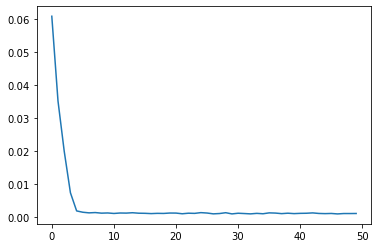

In [130]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 1000
n_iters = 50000

for i in range(n_iters):
    
    rand_index = np.random.choice(np.arange(0, X_train.shape[0]), 1)
    
    torch_X_train = torch.from_numpy(X_train[rand_index])
    torch_y_train = torch.from_numpy(y_train[rand_index])
    
    output, loss = train(torch_X_train[0], torch_y_train)
    current_loss += loss
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        print(f"{i} {i/n_iters*100:.1f} {loss:.4f}")
        
plt.figure()
plt.plot(all_losses)
plt.show()

### Test new model

In [167]:
predictions = np.array([])

n_iterations = data_test_scaled.shape[0]

#Get only first 50 samples
X_test = data_test_scaled
X_test = np.array(X_test, dtype=np.float32)

with torch.no_grad():
        
    for i in range(n_iterations):
        
        #skip 5 trainings
        if i%5 == 0:
            hidden = lstm.init_hidden()
            cell = lstm.init_hidden()

            torch_X_test = torch.from_numpy(X_test[i:50+i])


            for j in range(torch_X_test.size()[0]):
                output, hidden, cell = lstm(torch.reshape(torch_X_test[j], [1, 1]), hidden, cell)

            predictions = np.append(predictions, output[0].numpy())

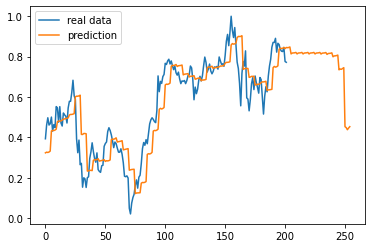

In [168]:
plt.plot(data_test_scaled[50:])
plt.plot(predictions)
plt.legend(["real data", "prediction"])
plt.show()

In [175]:
predictions = np.array([])

n_iterations = data_test_scaled.shape[0]

#Get only first 50 samples
X_test = data_test_scaled[0:50]
X_test = np.array(X_test, dtype=np.float32)

with torch.no_grad():
        
    for i in range(n_iterations):
        
        #skip 5 trainings
        if i%5 == 0:
            hidden = lstm.init_hidden()
            cell = lstm.init_hidden()

            torch_X_test = torch.from_numpy(X_test[i:50+i])


            for j in range(torch_X_test.size()[0]):
                output, hidden, cell = lstm(torch.reshape(torch_X_test[j], [1, 1]), hidden, cell)

            #Add new prediction to test dataset
            X_test = np.append(X_test, output[0].numpy())

            predictions = np.append(predictions, output[0].numpy())

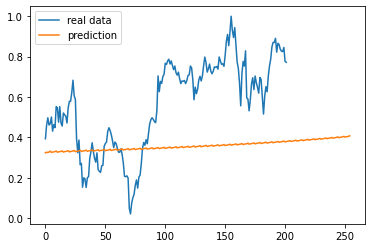

In [176]:
plt.plot(data_test_scaled[50:])
plt.plot(predictions)
plt.legend(["real data", "prediction"])
plt.show()

### Notes

* Results seem very optimistic, however since we are just predicting the following day taking the las 50 days as training set, even if the model predicts the same value as the previous day with just a small variation, at the end we will have a very similar curve prediction as saw in the first plot. In the second plot, we see this behavior, the predicted curve behaves very smothly since the model only precicts the last value with an slight variation.

* Try to modify the model, so it outputs more days in advance, not just one and check the result output.

### ToDo

* When predicting 5 days ahead and ploting, it seems to work well, but check if everything is correct.
* Try predicting 10, 15 days ahead
* Try with a bigger test sample

### Resources

* https://www.kaggle.com/tmtdmr/rnn-vs-lstm-on-google-stock-price-dataset